# Introduction: Improvements to Taxi Fare Prediction

In this notebook, we will attempt to improve upon our earlier efforts in the taxi fare prediction challenge. I'll take some of my advice and explore some other options.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

In [2]:
data = pd.read_csv('input/clean_data.csv')
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,manhattan,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration
0,4.500,-73.844,40.721,-73.842,40.712,1,"(0, 5]",0.009,0.003,0.012,...,26,21,365,0.727,0.104,0.507,0.456,14318735.000,2.700,6.000
1,16.900,-74.016,40.711,-73.979,40.782,1,"(15, 20]",0.071,0.037,0.107,...,52,16,365,0.703,0.243,0.178,0.016,31942290.000,8.900,28.000
2,5.700,-73.983,40.761,-73.991,40.751,2,"(05, 10]",0.011,0.009,0.019,...,35,0,365,0.024,0.432,0.563,0.628,82859654.000,2.400,13.000
3,7.700,-73.987,40.733,-73.992,40.758,1,"(05, 10]",0.025,0.004,0.029,...,30,42,366,0.188,0.741,0.683,0.306,104214596.000,4.500,21.000
4,5.300,-73.968,40.768,-73.957,40.784,1,"(05, 10]",0.016,0.011,0.027,...,51,0,365,0.327,0.190,0.291,0.187,37353014.000,2.300,9.000


In [34]:
test = pd.read_csv('input/clean_test.csv')
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,haversine,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration
0,-73.973,40.764,-73.981,40.744,1,0.020,0.008,0.028,0.022,2.326,...,8,24,365,0.547,0.221,0.861,0.075,191596058.000,2.700,11.000
1,-73.987,40.719,-73.999,40.739,1,0.020,0.012,0.032,0.023,2.428,...,8,24,365,0.547,0.221,0.861,0.075,191596058.000,3.400,15.000
2,-73.983,40.751,-73.980,40.746,1,0.005,0.003,0.008,0.006,0.619,...,53,44,365,0.496,0.785,0.265,0.769,87306778.000,1.000,1.000
3,-73.981,40.768,-73.990,40.752,1,0.016,0.009,0.025,0.019,1.963,...,12,12,366,0.883,0.840,0.059,0.918,123628286.000,3.400,18.000
4,-73.966,40.790,-73.989,40.744,1,0.045,0.023,0.068,0.051,5.393,...,12,12,366,0.883,0.840,0.059,0.918,123628286.000,9.900,27.000


In [49]:
test_id = list(pd.read_csv('input/test.csv', usecols = ['key'])['key'])

In [51]:
len(test)

9914

In [50]:
len(test_id)

9914

In [52]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 25, max_depth = 25,
                                           n_jobs = -1, verbose = 1)):
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False)
    
    return sub, feature_importances

In [53]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_month', 'pickup_frac_year',
                 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features + ['distance', 'duration']

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data, data['fare_amount'], random_state = RSEED,
                                                      stratify = data['fare-bin'], test_size = 1_000_000)

In [55]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, features)

[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  3.7min remaining:   55.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.1min finished
[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:    5.9s remaining:    1.5s
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:    6.2s finished
[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:    1.6s finished


Training:   rmse = 2.08 	 mape = 12.58
Validation: rmse = 3.36 	 mape = 16.95


[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:    0.0s finished


In [47]:
len(test_id)

1

In [48]:
test_id

['key']

In [56]:
fi

,feature,importance
2,haversine,0.802
11,pickup_Elapsed,0.034
6,dropoff_longitude,0.029
1,abs_lon_diff,0.025
12,distance,0.021
4,pickup_longitude,0.016
7,pickup_frac_day,0.014
5,dropoff_latitude,0.013
3,pickup_latitude,0.010
8,pickup_frac_week,0.009


In [57]:
sub.to_csv('rf_unaltered.csv', index = False)

In [58]:
test_rounded[(test_rounded['destination'].str.contains('JFK')) | (test_rounded['origin'].str.contains('JFK'))]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration,origin,destination
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014,40.710,-73.995,40.741,1,34.300,44.000,"One Liberty Plaza, New York, NY 10006, USA","JFK Expressway, Jamaica, NY 11430, USA"
76,2014-06-14 13:39:00.000000147,2014-06-14 13:39:00 UTC,-73.782,40.645,-73.972,40.640,1,28.400,40.000,"JFK Access Rd, Jamaica, NY 11430, USA","56 E 54th St, New York, NY 10022, USA"
352,2009-06-10 16:55:00.000000144,2009-06-10 16:55:00 UTC,-73.782,40.644,-73.782,40.644,1,26.900,37.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","168 W 34th St, New York, NY 10001, USA"
542,2014-06-15 07:06:00.00000036,2014-06-15 07:06:00 UTC,-73.803,40.648,-73.987,40.668,1,1.300,2.000,"148th St & JFK Expressway, Jamaica, NY 11430, USA","JFK Expressway, Jamaica, NY 11430, USA"
1428,2012-11-03 17:11:00.00000027,2012-11-03 17:11:00 UTC,-73.980,40.684,-73.981,40.681,1,27.700,38.000,"Cargo Link Air Freight Inc., Building #67 Suit...","79 Park Ave, New York, NY 10016, USA"
2455,2010-09-20 16:48:00.000000118,2010-09-20 16:48:00 UTC,-73.989,40.754,-73.943,40.823,1,27.800,36.000,"266 W 37th St, New York, NY 10018, USA","JFK Access Rd, Jamaica, NY 11430, USA"
2491,2012-08-20 14:47:36.0000004,2012-08-20 14:47:36 UTC,-73.790,40.647,-73.702,40.772,1,16.700,23.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","60-16 84th St, Middle Village, NY 11379, USA"
2718,2010-06-29 00:22:24.0000002,2010-06-29 00:22:24 UTC,-73.783,40.649,-73.983,40.781,1,26.600,40.000,"JFK Expressway, Jamaica, NY 11430, USA","127 W 30th St, New York, NY 10001, USA"
3569,2013-09-25 22:00:00.000000246,2013-09-25 22:00:00 UTC,-73.777,40.645,-73.918,40.872,1,27.400,35.000,"Van Wyck Expy & JFK Expressway, Jamaica, NY 11...","150 E 34th St, New York, NY 10016, USA"
4270,2009-11-07 16:37:49.0000002,2009-11-07 16:37:49 UTC,-73.777,40.645,-74.017,40.709,1,20.000,27.000,"JFK Access Rd, Jamaica, NY 11430, USA","153-1 28th Ave, Flushing, NY 11354, USA"


In [77]:
test_rounded[((test_rounded['destination'].str.contains('JFK Access Rd &')) | (test_rounded['origin'].str.contains('JFK Access Rd &'))) & (test_rounded['distance'] > 5)]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration,origin,destination
352,2009-06-10 16:55:00.000000144,2009-06-10 16:55:00 UTC,-73.782,40.644,-73.782,40.644,1,26.900,37.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","168 W 34th St, New York, NY 10001, USA"
2491,2012-08-20 14:47:36.0000004,2012-08-20 14:47:36 UTC,-73.790,40.647,-73.702,40.772,1,16.700,23.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","60-16 84th St, Middle Village, NY 11379, USA"
8255,2013-10-09 17:27:39.0000001,2013-10-09 17:27:39 UTC,-73.782,40.645,-73.981,40.743,2,30.800,50.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","141 Perry St, New York, NY 10014, USA"
9345,2014-10-27 14:58:00.000000149,2014-10-27 14:58:00 UTC,-73.777,40.646,-73.991,40.743,5,30.500,46.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","520 LaGuardia Pl, New York, NY 10012, USA"


In [87]:
sub = pd.read_csv('rf_unaltered.csv')

In [88]:
airport_keys = list(test_rounded.loc[((test_rounded['destination'].str.contains('JFK Access Rd &')) | (test_rounded['origin'].str.contains('JFK Access Rd &'))) & (test_rounded['distance'] > 5), 'key'])
sub.loc[sub['key'].isin(airport_keys), 'fare_amount'] = 45.0

In [89]:
airport_keys

['2009-06-10 16:55:00.000000144',
 '2012-08-20 14:47:36.0000004',
 '2013-10-09 17:27:39.0000001',
 '2014-10-27 14:58:00.000000149']

In [90]:
sub.loc[sub['key'].isin(airport_keys), 'fare_amount']

352    45.000
2491   45.000
8255   45.000
9345   45.000
Name: fare_amount, dtype: float64

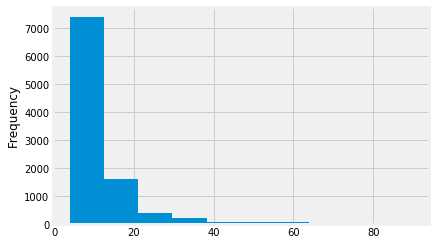

In [91]:
sub['fare_amount'].plot.hist()

In [92]:
sub.to_csv('rf_domain.csv', index = False)

# Investigate Fares

In [4]:
data = data.loc[data['fare_amount'].between(2.5, 100)]
data.shape

(4892578, 31)

In [6]:
div_5 = data[data['fare_amount'] % 5 == 0]
div_5.shape

(232095, 31)

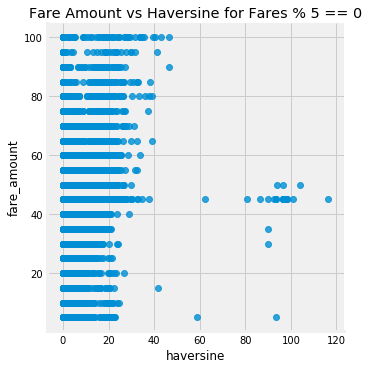

In [7]:
sns.lmplot('haversine', 'fare_amount', data = div_5, fit_reg = False);
plt.title('Fare Amount vs Haversine for Fares % 5 == 0');

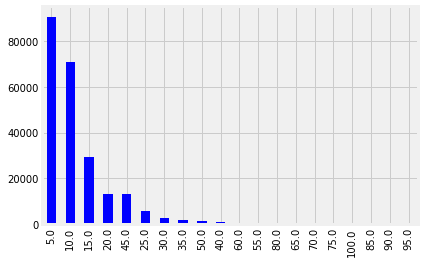

In [13]:
div_5['fare_amount'].value_counts().plot.bar(color = 'b');

In [16]:
div_5['color'] = ['blue' if x == 45 else 'red' for x in div_5['fare_amount']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

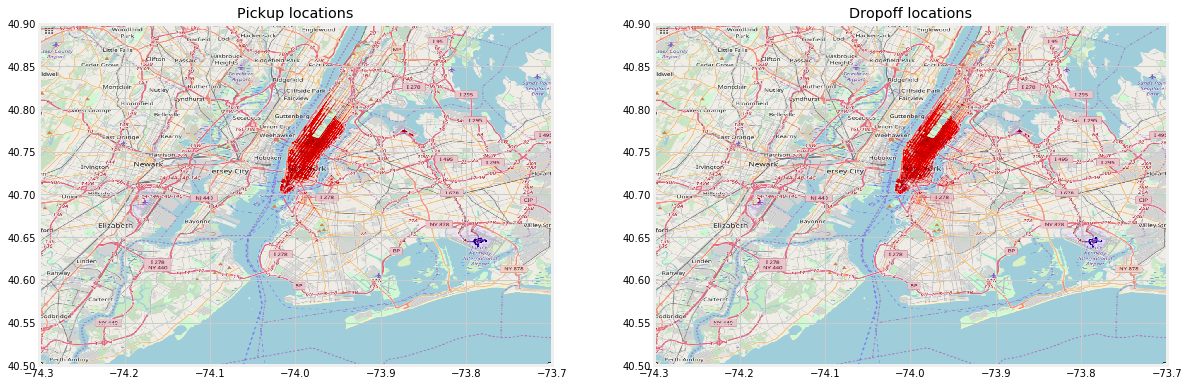

In [24]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(18, 16))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c=df['color'], s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c=df['color'], s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(div_5, BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

In [25]:
air = div_5[div_5['fare_amount'] == 45]

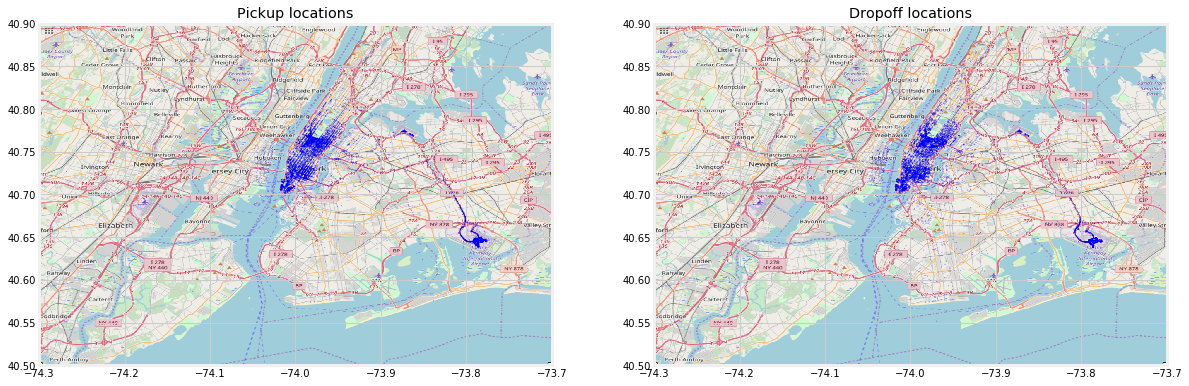

In [26]:
# plot training data on map zoomed in
plot_on_map(air, BB_zoom, nyc_map_zoom, s=0.15, alpha=0.5)

In [27]:
test_rounded = pd.read_csv('input/test_rounded_distances-3digits.csv')
test_rounded[test_rounded['destination'].str.contains('JFK')]

,key,distance,duration,origin,destination
8,2011-10-06 12:10:20.0000002,34.300,44.000,"One Liberty Plaza, New York, NY 10006, USA","JFK Expressway, Jamaica, NY 11430, USA"
542,2014-06-15 07:06:00.00000036,1.300,2.000,"148th St & JFK Expressway, Jamaica, NY 11430, USA","JFK Expressway, Jamaica, NY 11430, USA"
2455,2010-09-20 16:48:00.000000118,27.800,36.000,"266 W 37th St, New York, NY 10018, USA","JFK Access Rd, Jamaica, NY 11430, USA"
7503,2010-09-20 16:48:00.00000084,1.000,1.000,"JFK Access Rd, Jamaica, NY 11430, USA","JFK Access Rd, Jamaica, NY 11430, USA"
7996,2009-01-06 07:36:34.0000005,29.300,35.000,"22 E 112th St, New York, NY 10029, USA","JFK Access Rd, Jamaica, NY 11430, USA"
8301,2010-12-31 13:32:39.0000002,28.000,33.000,"52 Madison Ave, New York, NY 10010, USA","JFK Access Rd, Jamaica, NY 11430, USA"


In [32]:
test_rounded = test.merge(test_rounded, on = 'key')
test_rounded.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration,origin,destination
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973,40.764,-73.981,40.744,1,3.600,16.000,"1 Grand Army Plaza, New York, NY 10020, USA","4 W 14th St, New York, NY 10011, USA"
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.987,40.719,-73.999,40.739,1,3.000,14.000,"100 Ludlow St, New York, NY 10002, USA","15 E 10th St, New York, NY 10003, USA"
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.983,40.751,-73.980,40.746,1,3.400,15.000,"33 E 40th St, New York, NY 10016, USA","225w W 14th St, New York, NY 10011, USA"
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981,40.768,-73.990,40.752,1,3.000,12.000,"40 E 66th St, New York, NY 10065, USA","2229 Broadway, New York, NY 10024, USA"
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966,40.790,-73.989,40.744,1,3.600,15.000,"2418 Broadway, New York, NY 10024, USA","205 W 56th St, New York, NY 10019, USA"


In [31]:
test = pd.read_csv('input/test.csv')

In [33]:
test_rounded[(test_rounded['destination'].str.contains('JFK')) | (test_rounded['origin'].str.contains('JFK')) ]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,duration,origin,destination
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014,40.710,-73.995,40.741,1,34.300,44.000,"One Liberty Plaza, New York, NY 10006, USA","JFK Expressway, Jamaica, NY 11430, USA"
76,2014-06-14 13:39:00.000000147,2014-06-14 13:39:00 UTC,-73.782,40.645,-73.972,40.640,1,28.400,40.000,"JFK Access Rd, Jamaica, NY 11430, USA","56 E 54th St, New York, NY 10022, USA"
352,2009-06-10 16:55:00.000000144,2009-06-10 16:55:00 UTC,-73.782,40.644,-73.782,40.644,1,26.900,37.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","168 W 34th St, New York, NY 10001, USA"
542,2014-06-15 07:06:00.00000036,2014-06-15 07:06:00 UTC,-73.803,40.648,-73.987,40.668,1,1.300,2.000,"148th St & JFK Expressway, Jamaica, NY 11430, USA","JFK Expressway, Jamaica, NY 11430, USA"
1428,2012-11-03 17:11:00.00000027,2012-11-03 17:11:00 UTC,-73.980,40.684,-73.981,40.681,1,27.700,38.000,"Cargo Link Air Freight Inc., Building #67 Suit...","79 Park Ave, New York, NY 10016, USA"
2455,2010-09-20 16:48:00.000000118,2010-09-20 16:48:00 UTC,-73.989,40.754,-73.943,40.823,1,27.800,36.000,"266 W 37th St, New York, NY 10018, USA","JFK Access Rd, Jamaica, NY 11430, USA"
2491,2012-08-20 14:47:36.0000004,2012-08-20 14:47:36 UTC,-73.790,40.647,-73.702,40.772,1,16.700,23.000,"JFK Access Rd & Van Wyck Expy, Jamaica, NY 114...","60-16 84th St, Middle Village, NY 11379, USA"
2718,2010-06-29 00:22:24.0000002,2010-06-29 00:22:24 UTC,-73.783,40.649,-73.983,40.781,1,26.600,40.000,"JFK Expressway, Jamaica, NY 11430, USA","127 W 30th St, New York, NY 10001, USA"
3569,2013-09-25 22:00:00.000000246,2013-09-25 22:00:00 UTC,-73.777,40.645,-73.918,40.872,1,27.400,35.000,"Van Wyck Expy & JFK Expressway, Jamaica, NY 11...","150 E 34th St, New York, NY 10016, USA"
4270,2009-11-07 16:37:49.0000002,2009-11-07 16:37:49 UTC,-73.777,40.645,-74.017,40.709,1,20.000,27.000,"JFK Access Rd, Jamaica, NY 11430, USA","153-1 28th Ave, Flushing, NY 11354, USA"


In [28]:
test_rounded.shape

(9914, 5)

In [8]:
div_5[div_5['fare_amount'] == 45]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,manhattan,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration
701,45.000,-73.999,40.754,-73.863,40.668,1,"(40, 45]",0.087,0.136,0.223,...,42,16,365,0.988,0.570,0.562,0.049,127698090.000,21.200,43.000
781,45.000,-73.970,40.751,-73.782,40.649,1,"(40, 45]",0.102,0.188,0.290,...,18,0,366,0.638,0.948,0.421,0.119,98291834.000,27.900,32.000
1723,45.000,-74.003,40.733,-73.776,40.645,1,"(40, 45]",0.088,0.227,0.315,...,39,0,365,0.235,0.034,0.588,0.296,72337094.000,31.000,46.000
1755,45.000,-73.790,40.647,-73.964,40.766,1,"(40, 45]",0.119,0.174,0.293,...,28,0,366,0.686,0.527,0.615,0.550,111947234.000,32.300,41.000
1824,45.000,-74.011,40.709,-73.786,40.644,2,"(40, 45]",0.064,0.225,0.289,...,41,10,366,0.654,0.093,0.208,0.599,113499624.000,33.100,42.000
2233,45.000,-73.787,40.641,-73.969,40.578,2,"(40, 45]",0.064,0.182,0.245,...,35,49,365,0.983,0.283,0.187,0.178,131758503.000,24.800,28.000
2342,45.000,-73.789,40.641,-74.012,40.717,1,"(40, 45]",0.076,0.223,0.299,...,41,50,365,0.321,0.617,0.291,0.938,92648464.000,33.600,50.000
3254,45.000,-73.784,40.649,-73.962,40.768,2,"(40, 45]",0.119,0.178,0.297,...,4,22,365,0.753,0.536,0.492,0.043,1274616.000,33.000,41.000
3540,45.000,-73.782,40.645,-73.974,40.762,5,"(40, 45]",0.118,0.193,0.310,...,7,0,365,0.672,0.382,0.708,0.975,62265974.000,28.800,43.000
3682,45.000,-73.992,40.731,-73.790,40.647,2,"(40, 45]",0.084,0.202,0.286,...,11,0,365,0.633,0.519,0.504,0.289,40576214.000,28.000,35.000


The coordinates of JFK are: 40.6413° N, 73.7781° W

In [10]:
data[(data['pickup_latitude'].between(40.6, 40.7)) & (data['pickup_longitude'].between(-73.7, -73.8))]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,manhattan,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration


In [11]:
data[(data['dropoff_latitude'].between(40.6, 40.7)) & (data['dropoff_longitude'].between(-73.7, 73.8))]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,manhattan,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration
7642,95.000,-73.863,40.769,-73.652,40.658,2,[45+],0.111,0.211,0.322,...,50,35,365,0.368,0.053,0.105,0.755,86863789.000,36.500,37.000
23940,38.900,-73.786,40.650,-73.646,40.692,5,"(35, 40]",0.042,0.140,0.182,...,24,0,366,0.725,0.675,0.591,0.133,98731394.000,18.200,21.000
27369,35.000,-73.777,40.645,-73.628,40.640,1,"(30, 35]",0.005,0.149,0.154,...,32,35,365,0.606,0.229,0.644,0.636,146241109.000,21.400,28.000
42592,85.500,-73.871,40.774,-73.633,40.654,1,[45+],0.120,0.238,0.358,...,57,0,366,0.456,0.208,0.144,0.677,115988174.000,35.800,36.000
49242,8.900,-73.777,40.645,-73.588,40.633,5,"(05, 10]",0.012,0.189,0.201,...,40,0,365,0.028,0.575,0.323,0.691,53311154.000,31.400,31.000
60324,17.300,-73.782,40.645,-73.694,40.658,1,"(15, 20]",0.014,0.088,0.101,...,20,52,365,0.264,0.895,0.940,0.159,68019606.000,12.500,22.000
61208,6.500,-73.554,40.664,-73.553,40.666,1,"(05, 10]",0.002,0.001,0.003,...,53,0,365,0.787,0.255,0.509,0.707,22272734.000,1.400,4.000
66519,85.000,-73.779,40.647,-73.644,40.668,1,[45+],0.021,0.135,0.156,...,19,0,365,0.638,0.091,0.426,0.532,16730294.000,21.400,21.000
78620,6.500,-73.308,40.648,-73.329,40.630,1,"(05, 10]",0.017,0.021,0.039,...,30,0,365,0.771,0.253,0.368,0.778,87589754.000,3.200,3.000
84971,62.000,-73.864,40.770,-73.687,40.652,1,[45+],0.118,0.177,0.295,...,19,38,365,0.014,0.573,0.500,0.372,169431532.000,28.000,39.000


In [2]:
data = pd.read_csv('input/train.csv', nrows = 5_000_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
data = data.dropna()

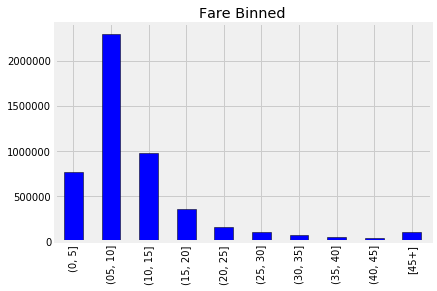

In [3]:
data = data[data['fare_amount'].between(left = 0, right = 100)]
data = data.loc[data['passenger_count'] < 10]

# Remove latitude and longtiude outliers
data = data.loc[data['pickup_latitude'].between(40, 42)]
data = data.loc[data['pickup_longitude'].between(-75, -72)]
data = data.loc[data['dropoff_latitude'].between(40, 42)]
data = data.loc[data['dropoff_longitude'].between(-75, -72)]

# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

In [4]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

data['manhattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)

data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

In [5]:
test = pd.read_csv('input/test.csv', parse_dates = ['pickup_datetime'])

test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

# Save the id for submission
test_id = list(test.pop('key'))

In [6]:
# Radius of hte earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

In [7]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')
    
from sklearn.ensemble import RandomForestRegressor

def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 25, max_depth = 25,
                                           n_jobs = -1)):
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False).set_index('feature')
    
    return sub, feature_importances

In [8]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())

data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())

# Rounded Distances

In [9]:
rounded_names = []
# Round to two places
for l in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    
    r = f'{l}-round'
    data[r] = data[l].round(2)
    test[r] = test[l].round(2)
    rounded_names.append(r)
    
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,...,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round
0,2015-01-27 13:08:24,-73.973,40.764,-73.981,40.744,1,0.020,0.008,0.028,0.022,...,365,0.547,0.221,0.861,0.075,191596058.000,40.760,-73.970,40.740,-73.980
1,2015-01-27 13:08:24,-73.987,40.719,-73.999,40.739,1,0.020,0.012,0.032,0.023,...,365,0.547,0.221,0.861,0.075,191596058.000,40.720,-73.990,40.740,-74.000
2,2011-10-08 11:53:44,-73.983,40.751,-73.980,40.746,1,0.005,0.003,0.008,0.006,...,365,0.496,0.785,0.265,0.769,87306778.000,40.750,-73.980,40.750,-73.980
3,2012-12-01 21:12:12,-73.981,40.768,-73.990,40.752,1,0.016,0.009,0.025,0.019,...,366,0.883,0.840,0.059,0.918,123628286.000,40.770,-73.980,40.750,-73.990
4,2012-12-01 21:12:12,-73.966,40.790,-73.989,40.744,1,0.045,0.023,0.068,0.051,...,366,0.883,0.840,0.059,0.918,123628286.000,40.790,-73.970,40.740,-73.990


In [10]:
test_round = pd.read_csv('input/test_rounded_distances.csv')
test_round.columns = rounded_names + list(test_round.columns[4:])
test_round.head()

,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round,pickup,dropoff,distance,duration
0,40.570,-74.220,40.570,-74.220,"40.57,-74.22","40.57,-74.22",1.000,1.000
1,40.580,-74.250,40.590,-74.260,"40.58,-74.25","40.59,-74.26",3.600,8.000
2,40.590,-73.970,40.590,-73.970,"40.59,-73.97","40.59,-73.97",1.000,1.000
3,40.600,-73.980,40.600,-73.970,"40.6,-73.98","40.6,-73.97",1.500,6.000
4,40.620,-73.990,40.620,-73.990,"40.62,-73.99","40.62,-73.99",1.000,1.000


In [11]:
test = test.merge(test_round, on = rounded_names, how = 'left')

In [12]:
data_round = pd.read_csv('input/rounded_distances.csv')
data_round.columns = rounded_names + list(data_round.columns[4:])
data = data.merge(data_round, on = rounded_names, how = 'left')
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,...,pickup_frac_year,pickup_Elapsed,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round,pickup,dropoff,distance,duration
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1,"(0, 5]",0.009,0.003,...,0.456,14318735.000,40.720,-73.840,40.710,-73.840,"40.72,-73.84","40.71,-73.84",2.700,6.000
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1,"(15, 20]",0.071,0.037,...,0.016,31942290.000,40.710,-74.020,40.780,-73.980,"40.71,-74.02","40.78,-73.98",8.900,28.000
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2,"(05, 10]",0.011,0.009,...,0.628,82859654.000,40.760,-73.980,40.750,-73.990,"40.76,-73.98","40.75,-73.99",2.400,13.000
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1,"(05, 10]",0.025,0.004,...,0.306,104214596.000,40.730,-73.990,40.760,-73.990,"40.73,-73.99","40.76,-73.99",4.500,21.000
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1,"(05, 10]",0.016,0.011,...,0.187,37353014.000,40.770,-73.970,40.780,-73.960,"40.77,-73.97","40.78,-73.96",2.300,9.000


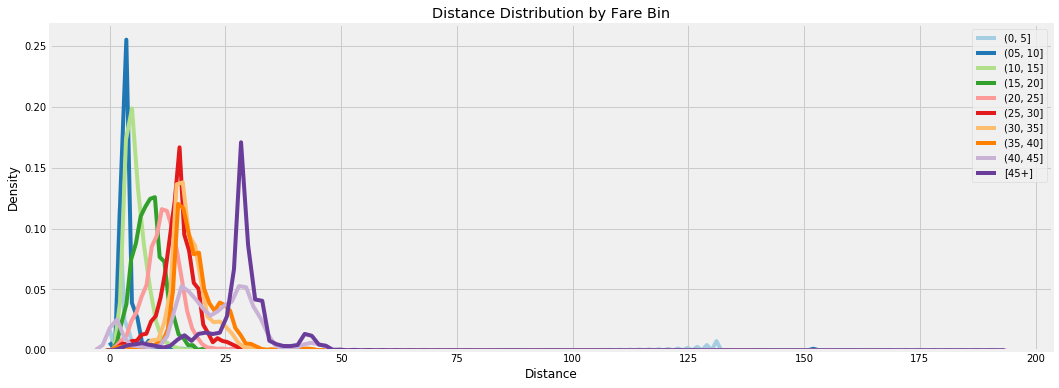

In [13]:
plt.figure(figsize = (16, 6))

for i, (f, grouped) in enumerate(data.groupby('fare-bin')):
    sns.kdeplot(grouped['distance'], label = f'{f}', color = palette[i])

plt.xlabel('Distance'); plt.ylabel('Density'); plt.title('Distance Distribution by Fare Bin');

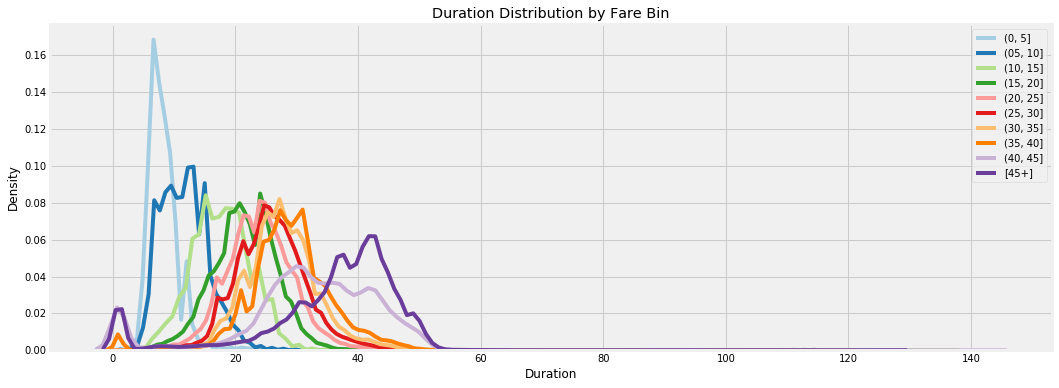

In [14]:
plt.figure(figsize = (16, 6))

for i, (f, grouped) in enumerate(data.groupby('fare-bin')):
    sns.kdeplot(grouped['duration'], label = f'{f}', color = palette[i])

plt.xlabel('Duration'); plt.ylabel('Density'); plt.title('Duration Distribution by Fare Bin');

In [15]:
data = data.fillna(0)
test = test.fillna(0)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

In [17]:
features = list(data.columns)

for f in ['pickup_datetime', 'fare_amount', 'fare-bin', 'pickup', 'dropoff'] + rounded_names:
    features.remove(f)
    
len(features)

29

In [18]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, features)

Training:   rmse = 2.04 	 mape = 13.33
Validation: rmse = 3.38 	 mape = 17.92


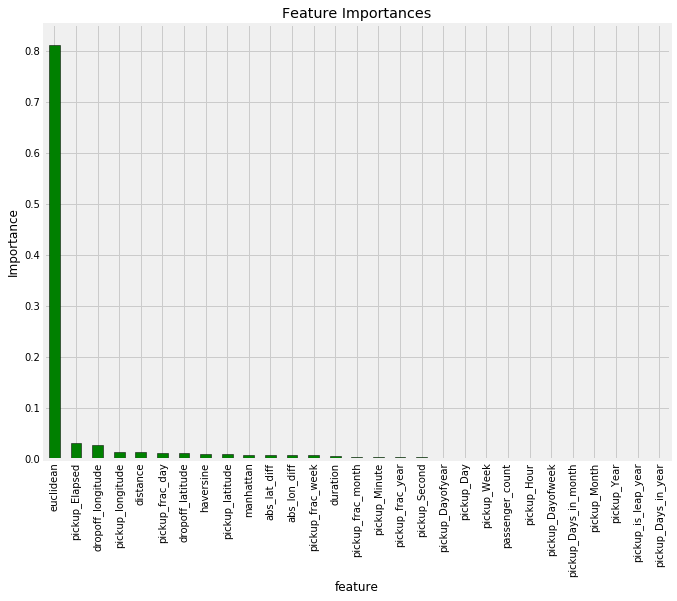

In [32]:
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [41]:
features = list(fi[fi['importance'] > 0.005].index)
len(features)

13

In [22]:
corrs = data.corr()

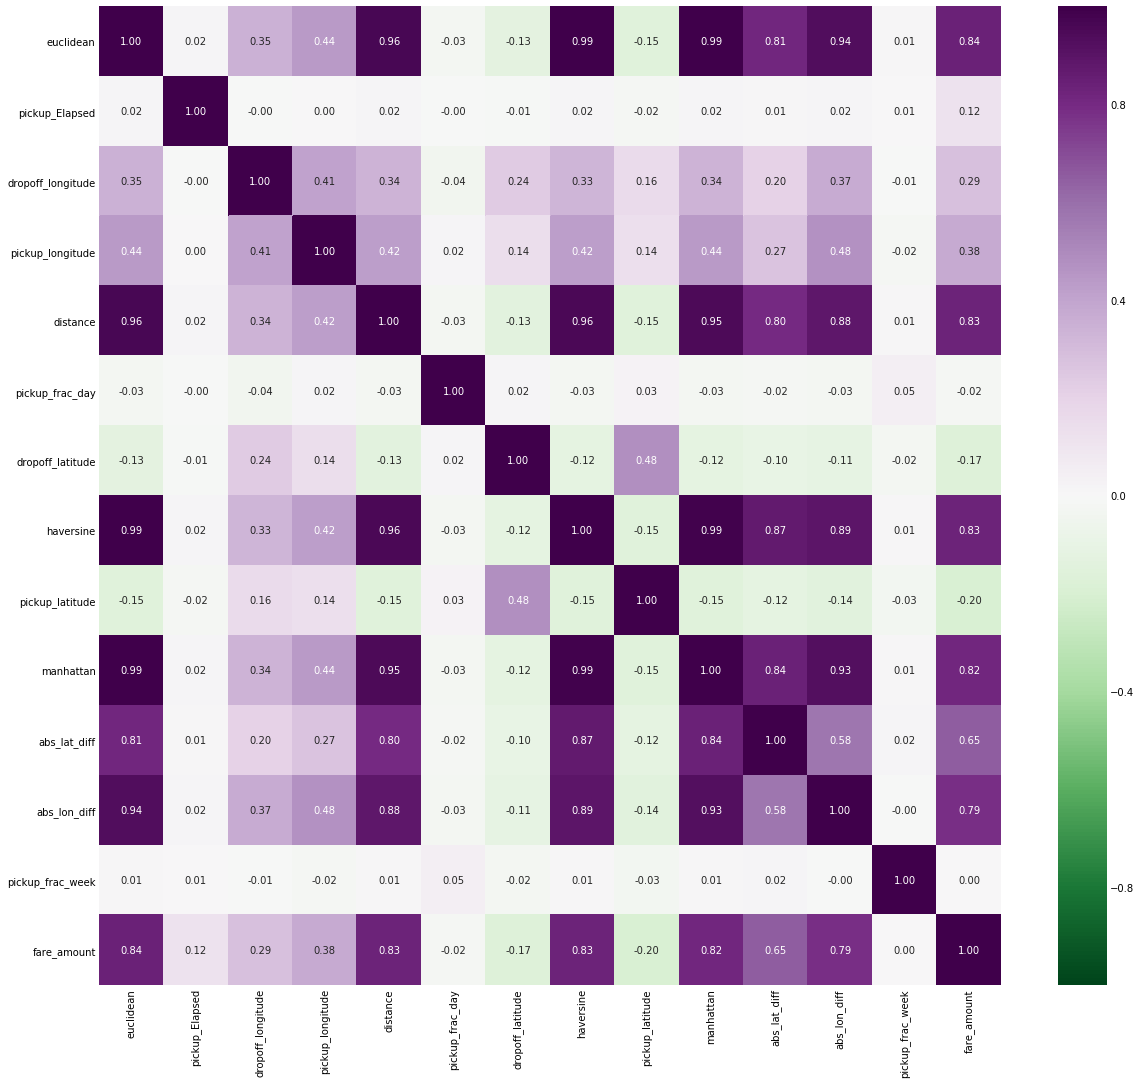

In [43]:
corrs = corrs.loc[features + ['fare_amount'], features + ['fare_amount']]
plt.figure(figsize = (18, 18))
sns.heatmap(corrs, annot = True, fmt = '.2f', vmin = -1, vmax = 1, cmap = plt.cm.PRGn_r);

In [55]:
from sklearn.model_selection import KFold

import lightgbm as lgb

In [52]:
trial_data = data.sample(100_000, random_state=RSEED)

In [73]:
def model_gbm(data, targets, feature_names, test, test_id, 
              nfolds = 3, hyp = None):
    """Model using the gradient boosting machine. Using
    early stopping with cross validation to make predictions.
    """
    
    # Option for user specified hyperparameters
#     if hyp is not None:
#         # Using early stopping so do not need number of esimators
#         if 'n_estimators' in hyp:
#             del hyp['n_estimators']
#         params = hyp
    
#     else:
#         # Model hyperparameters
#         params = {'boosting_type': 'dart', 
#                   'colsample_bytree': 0.88, 
#                   'learning_rate': 0.028, 
#                    'min_child_samples': 10, 
#                    'num_leaves': 36, 'reg_alpha': 0.76, 
#                    'reg_lambda': 0.43, 
#                    'subsample_for_bin': 40000, 
#                    'subsample': 0.54}
    
    # Build the model
    model = lgb.LGBMRegressor(objective = 'regression', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = RSEED)
    
    # Using KFOLD
    kfold = KFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = np.zeros(len(test))
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    data = np.array(data[feature_names])
    test = np.array(test[feature_names])
    targets = np.array(targets).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(kfold.split(data, targets)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = data[train_indices]
        X_valid = data[valid_indices]
        y_train = targets[train_indices]
        y_valid = targets[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = 'root_mean_squared_error',
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 500)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['rmse'])
        
        # Make predictions from the fold
        predictions = model.predict(test) / nfolds
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        # display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    
    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    sub = pd.DataFrame({'key': test_id, 'fare_amount': predictions})
    
    # return the submission and feature importances
    return sub, feature_importances

In [74]:
sub, fi = model_gbm(data, data['fare_amount'], features, test, test_id)

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 3.18487	valid's rmse: 3.27628
[1000]	train's rmse: 3.08898	valid's rmse: 3.25126
[1500]	train's rmse: 3.02194	valid's rmse: 3.24039
[2000]	train's rmse: 2.96949	valid's rmse: 3.23611
[2500]	train's rmse: 2.92505	valid's rmse: 3.23403
Early stopping, best iteration is:
[2590]	train's rmse: 2.91695	valid's rmse: 3.23365


'Fold 1, Validation Score: 3.23365, Estimators Trained: 2590'

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 3.17852	valid's rmse: 3.29786
[1000]	train's rmse: 3.08297	valid's rmse: 3.26962
[1500]	train's rmse: 3.01924	valid's rmse: 3.2605
[2000]	train's rmse: 2.96632	valid's rmse: 3.25499
Early stopping, best iteration is:
[2014]	train's rmse: 2.96518	valid's rmse: 3.25486


'Fold 2, Validation Score: 3.25486, Estimators Trained: 2014'

Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 3.18127	valid's rmse: 3.27422
[1000]	train's rmse: 3.0854	valid's rmse: 3.2483
[1500]	train's rmse: 3.01882	valid's rmse: 3.23776
[2000]	train's rmse: 2.96545	valid's rmse: 3.23267
[2500]	train's rmse: 2.92071	valid's rmse: 3.23016
Early stopping, best iteration is:
[2459]	train's rmse: 2.92459	valid's rmse: 3.22971


'Fold 3, Validation Score: 3.22971, Estimators Trained: 2459'

'3 cross validation score: 3.23941 with std: 0.01104.'

In [75]:
sub.to_csv('sub_gbm.csv', index = False)

## Save Data for Future Use

In [76]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,...,pickup_frac_year,pickup_Elapsed,pickup_latitude-round,pickup_longitude-round,dropoff_latitude-round,dropoff_longitude-round,pickup,dropoff,distance,duration
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1,"(0, 5]",0.009,0.003,...,0.456,14318735.000,40.720,-73.840,40.710,-73.840,"40.72,-73.84","40.71,-73.84",2.700,6.000
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1,"(15, 20]",0.071,0.037,...,0.016,31942290.000,40.710,-74.020,40.780,-73.980,"40.71,-74.02","40.78,-73.98",8.900,28.000
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2,"(05, 10]",0.011,0.009,...,0.628,82859654.000,40.760,-73.980,40.750,-73.990,"40.76,-73.98","40.75,-73.99",2.400,13.000
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1,"(05, 10]",0.025,0.004,...,0.306,104214596.000,40.730,-73.990,40.760,-73.990,"40.73,-73.99","40.76,-73.99",4.500,21.000
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1,"(05, 10]",0.016,0.011,...,0.187,37353014.000,40.770,-73.970,40.780,-73.960,"40.77,-73.97","40.78,-73.96",2.300,9.000


In [77]:
data.shape

(4892738, 38)

In [80]:
to_drop = ['pickup_datetime', 'pickup_latitude-round', 'pickup_longitude-round',
           'dropoff_latitude-round', 'dropoff_longitude-round', 'pickup', 'dropoff']

data = data.drop(columns = to_drop)
test = test.drop(columns = to_drop)

In [81]:
test.shape

(9914, 29)

In [82]:
data.shape

(4892738, 31)

In [83]:
data.to_csv('input/clean_data.csv', index = False)
test.to_csv('input/clean_test.csv', index = False)